# Robust Neural Network: 2D toy example

In this example, we train a simple network that is robust to adversarial noise. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")

import numpy as np

In [2]:
import sys
import warnings

## warning 없애기
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()

## Baseline: cross entropy loss

In [4]:
net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)

opt = optim.Adam(net.parameters(), lr=1e-3)
for i in range(1000):
    out = net(Variable(X))
    l = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    if i % 100 == 0:
        print(l.data[0], err)
    opt.zero_grad()
    (l).backward()
    opt.step()
print(l.data[0])

tensor(0.6937) tensor(0.5833)
tensor(0.1794) tensor(0.0833)
tensor(0.0034) tensor(0.)
tensor(0.0009) tensor(0.)
tensor(0.0004) tensor(0.)
tensor(0.0003) tensor(0.)
tensor(0.0002) tensor(0.)
tensor(0.0001) tensor(0.)
tensor(0.0001) tensor(0.)
tensor(0.0001) tensor(0.)
tensor(0.0001)


### Visualization: learned baseline classifier 

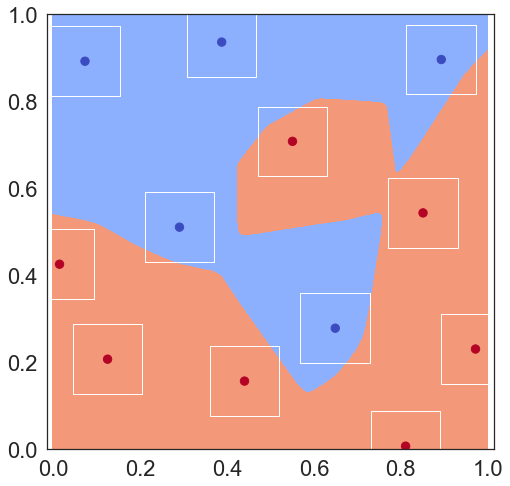

In [5]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

## Robust Neural Network

In [6]:
import sys
sys.path.append("../")
from convex_adversarial import robust_loss

torch.manual_seed(1)
robust_net = nn.Sequential(
    nn.Linear(2,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2)
)
data = []
opt = optim.Adam(robust_net.parameters(), lr=1e-3)
for i in range(1000):
    robust_ce, robust_err = robust_loss(robust_net, epsilon, X, y)
    out = robust_net(X)
    l2 = nn.CrossEntropyLoss()(out, Variable(y))
    err = (out.max(1)[1].data != y).float().mean()
    data.append([l2.data[0], robust_ce.data[0], err, robust_err])
    if i % 100 == 0:
        print(robust_ce.data[0], robust_err)
    opt.zero_grad()
    (robust_ce).backward()
    opt.step()

print(l2.data[0], robust_ce.data[0], robust_err)

tensor(0.6904) 0.4166666666666667
tensor(0.5342) 0.25
tensor(0.2548) 0.08333333333333333
tensor(0.1015) 0.0
tensor(0.0369) 0.0
tensor(0.0121) 0.0
tensor(0.0058) 0.0
tensor(0.0032) 0.0
tensor(0.0021) 0.0
tensor(0.0014) 0.0
tensor(0.0001) tensor(0.0010) 0.0


In [7]:
robust_err

0.0

In [8]:
robust_ce

tensor(0.0010, grad_fn=<NllLossBackward>)

### Visualization: learned robust classifier

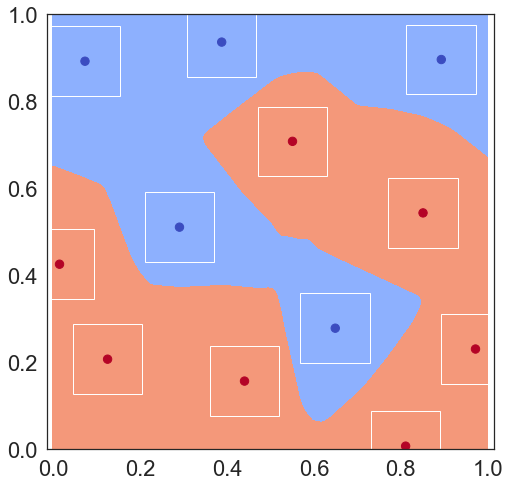

In [10]:
XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = robust_net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")
ax.axis([0,1,0,1])

for a in x:
    ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))

# Grid plots

In [11]:
def plot_grid(net, ax): 
    XX, YY = np.meshgrid(np.linspace(-0.1, 1.1, 100), np.linspace(-0.1, 1.1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100,100).data.numpy()

    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    ax.axis([0,1,0,1])

    for a in x:
        ax.add_patch(patches.Rectangle((a[0]-r/2, a[1]-r/2), r, r, fill=False))
    ax.set_yticks([0.0, 0.5, 1.0])
#     ax.set_xticks([])

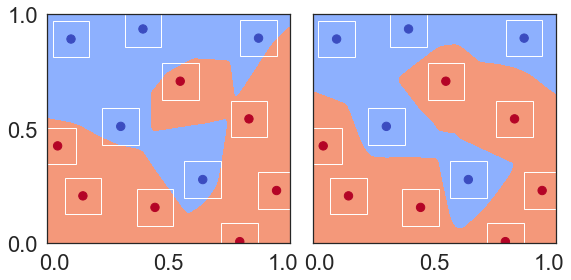

In [13]:
fig, axs = plt.subplots(1,2,figsize=(8,4), sharex=False, sharey=True)
plot_grid(net, axs[0])
plot_grid(robust_net, axs[1])
plt.tight_layout()
plt.savefig('2D_grid.pdf', bbox_inches='tight')

# Learning curves

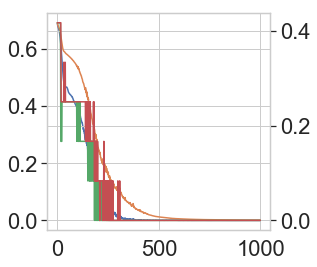

In [14]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, ax_loss = plt.subplots(1,1,figsize=(4,4))
ax_loss.plot(d[:,0], color='C0')
ax_loss.plot(d[:,1], color='C1')
ax_err = ax_loss.twinx()
ax_err.plot(d[:,2], color='C2')
ax_err.plot(d[:,3], color='C3')

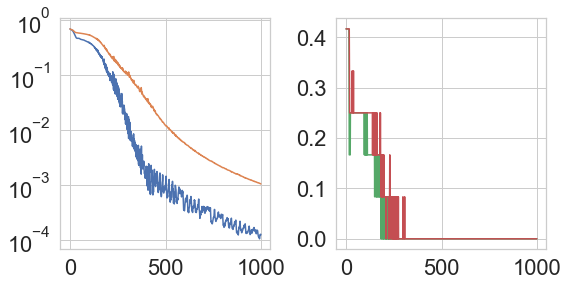

In [15]:
seaborn.set_style("whitegrid")
d = np.array(data)
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].semilogy(d[:,0], color='C0')
axs[0].semilogy(d[:,1], color='C1')
axs[1].plot(d[:,2], color='C2')
axs[1].plot(d[:,3], color='C3')
plt.tight_layout()
plt.savefig('2D_curves.pdf', bbox_inches='tight')

AttributeError: 'list' object has no attribute 'twinx'

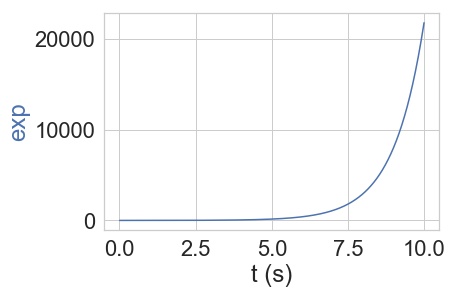

In [16]:

ax1 = plt.plot()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
plt.plot(t,s1,'b-')
plt.xlabel('t (s)')
plt.ylabel('exp',color='b')

ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(t, s2, 'r.')
plt.ylabel('sin', color='r')
plt.show()